# DA5401 Assignment #4
# GMM-Based Synthetic Sampling for Imbalanced Data

#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

## Part A: Baseline Model and Data Analysis

### 1. Data Loading & Analysis

- Load the dataset (creditcard.csv).
- Plotting class distribution and observing degree of imbalance

In [3]:
df = pd.read_csv('/content/creditcard.csv')
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class Distribution (Counts):
Class
0    284315
1       492
Name: count, dtype: int64

Class Distribution (Percentages):
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


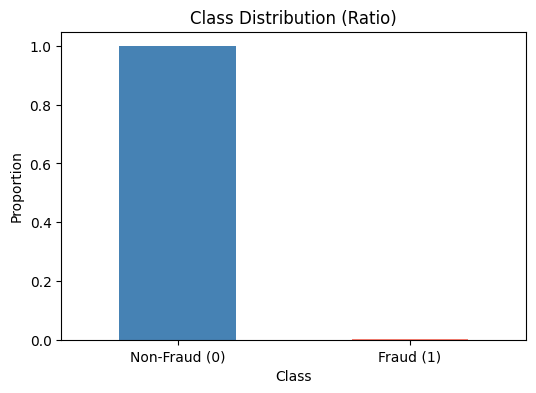

In [5]:
class_counts = df['Class'].value_counts()
total = len(df['Class'])

print("Class Distribution (Counts):")
print(class_counts)

print("\nClass Distribution (Percentages):")
print((class_counts / total) * 100)

plt.figure(figsize=(6,4))
(class_counts/total).plot(kind='bar', color=['steelblue','salmon'])
plt.title("Class Distribution (Ratio)")
plt.ylabel("Proportion")
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"], rotation=0)
plt.show()

### 2.Model Training (Baseline model)
We split the dataset into **training and testing sets**.  
- The **training set** is used for model learning.  
- The **test set** retains the original imbalance so evaluation reflects the real-world scenario.  

We then train a **Logistic Regression** classifier on the imbalanced training data.

In [7]:
X = df.drop(['Class'], axis=1)
y = df['Class']
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])
X['Time'] = scaler.fit_transform(X[['Time']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

### 3.Baseline Evaluation

In [9]:
print("Baseline Model (Imbalanced Data):")
print(classification_report(y_test, y_pred, digits=4))

Baseline Model (Imbalanced Data):
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56962
   macro avg     0.9142    0.8213    0.8619     56962
weighted avg     0.9991    0.9992    0.9991     56962



### Interpretation :
- Accuracy is Misleading (99.92%): This high score is due to class imbalance. A model that always predicts "no fraud" would also score ~99.5%, making accuracy a useless metric here.

- Strong Precision (83.12%): When the model predicts "fraud," it is correct 83% of the time. This minimizes false alarms.

- Critically Low Recall (65.31%): The model fails to catch ~35% of all real fraud cases. These missed cases (False Negatives) are the most critical and costly error.

- Mediocre F1-Score (0.7314): This score balances precision and recall, confirming the model's overall performance is inadequate for reliably detecting fraud.

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1. Theoritical Foundation

#### Difference between GMM-based Synthetic Sampling and SMOTE

#### SMOTE (Synthetic Minority Oversampling Technique)

- Works by selecting pairs of minority class samples and generating new points along the line segments connecting them.
- Assumes that the minority class is roughly continuous and evenly distributed in the feature space.
- It is deterministic and interpolation-based, not probabilistic.
- Limitation: SMOTE cannot capture multimodal or complex structures in the data distribution, and may generate unrealistic samples in sparse regions.

#### GMM (Gaussian Mixture Model)-based Synthetic Sampling

- Fits a probabilistic model (mixture of Gaussian distributions) to the minority class.
- Each Gaussian component represents a cluster or sub-distribution of the minority class.
- Synthetic samples are generated by sampling from the learned probability distribution.
- This allows more realistic and diverse synthetic points, especially in cases where the data distribution is multimodal or skewed.

2. Why GMM is Theoretically Better

- The minority class often has sub-groups (e.g., different fraud patterns in fraud detection).
- GMM can capture this by modeling the data as a weighted sum of multiple Gaussian distributions, each representing a subgroup.
- Unlike SMOTE, which only interpolates between existing points, GMM generalizes the underlying density, so synthetic samples are drawn from a distribution that closely mimics the real data.
- This reduces the risk of generating:
Unrealistic synthetic points in empty regions of the feature space.
- Overlapping with majority class regions (which can cause misclassification).

In summary, GMM-based sampling respects the geometry and probabilistic structure of the minority data, making it more robust and flexible for complex datasets.

Best GMM components by BIC: 3
Best GMM components by AIC: 19


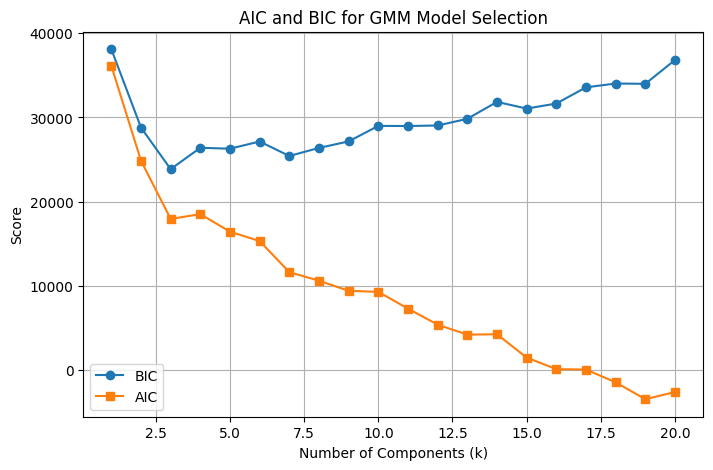

In [35]:
minority = X_train[y_train == 1]

lowest_bic = np.inf
lowest_aic = np.inf
bic = []
aic = []
n_components_range = range(1, 21)

best_gmm_bic = None
best_gmm_aic = None

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(minority)

    bic_val = gmm.bic(minority)
    aic_val = gmm.aic(minority)

    bic.append(bic_val)
    aic.append(aic_val)

    if bic_val < lowest_bic:
        lowest_bic = bic_val
        best_gmm_bic = gmm

    if aic_val < lowest_aic:
        lowest_aic = aic_val
        best_gmm_aic = gmm

print(f"Best GMM components by BIC: {best_gmm_bic.n_components}")
print(f"Best GMM components by AIC: {best_gmm_aic.n_components}")


plt.figure(figsize=(8,5))
plt.plot(n_components_range, bic, label='BIC', marker='o')
plt.plot(n_components_range, aic, label='AIC', marker='s')
plt.xlabel("Number of Components (k)")
plt.ylabel("Score")
plt.title("AIC and BIC for GMM Model Selection")
plt.legend()
plt.grid(True)
plt.show()


### Interpretation :
Based on the BIC curve, BIC is minimum at k=3

Therefore, we select k=3 as the optimal number of components, as it balances model complexity with generalization.

### Synthetic Data Generation: Oversampled only with GMM



In [16]:
n_majority = sum(y_train==0)
n_minority = sum(y_train==1)
n_to_generate = n_majority - n_minority

gmm_f = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_f.fit(minority)

synthetic_samples, _ = gmm_f.sample(n_to_generate)
synthetic_labels = np.ones(n_to_generate)

X_train_gmm = np.vstack([X_train, synthetic_samples])
y_train_gmm = np.hstack([y_train, synthetic_labels])

print("Original minority count:", n_minority)
print("Synthetic samples generated:", n_to_generate)
print("Balanced training size:", len(y_train_gmm))

Original minority count: 394
Synthetic samples generated: 227057
Balanced training size: 454902


### Rebalancing with CBU

Running KMeans with k=1...
Running KMeans with k=2...
Running KMeans with k=3...
Running KMeans with k=4...
Running KMeans with k=5...
Running KMeans with k=6...
Running KMeans with k=7...
Running KMeans with k=8...
Running KMeans with k=9...
Running KMeans with k=10...
Running KMeans with k=11...
Running KMeans with k=12...
Running KMeans with k=13...
Running KMeans with k=14...
Running KMeans with k=15...
Running KMeans with k=16...
Running KMeans with k=17...
Running KMeans with k=18...
Running KMeans with k=19...


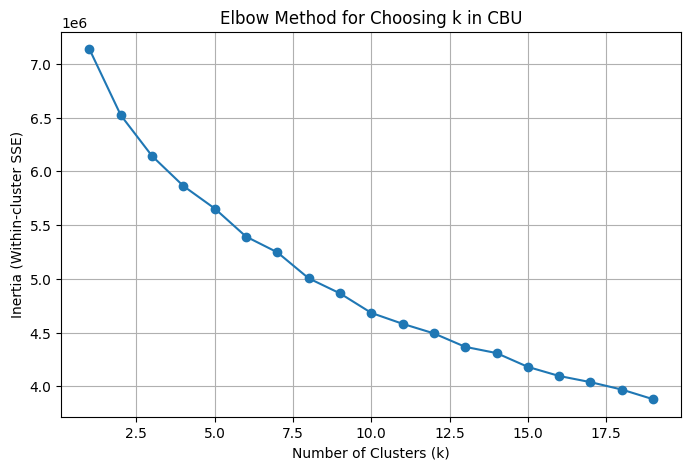

k=1: Inertia=7135874.46
k=2: Inertia=6522125.41
k=3: Inertia=6142282.27
k=4: Inertia=5863539.12
k=5: Inertia=5654196.25
k=6: Inertia=5392913.11
k=7: Inertia=5246558.17
k=8: Inertia=5004852.08
k=9: Inertia=4864773.23
k=10: Inertia=4683131.11
k=11: Inertia=4581738.98
k=12: Inertia=4492404.68
k=13: Inertia=4367273.87
k=14: Inertia=4309377.34
k=15: Inertia=4180885.51
k=16: Inertia=4096246.80
k=17: Inertia=4038987.92
k=18: Inertia=3969939.28
k=19: Inertia=3880056.43


In [33]:
majority = X_train[y_train == 0]

k_values = range(1,20)
inertias = []

for k in k_values:
    print(f"Running KMeans with k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(majority)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Method for Choosing k in CBU")
plt.grid(True)
plt.show()

for k, inertia in zip(k_values, inertias):
    print(f"k={k}: Inertia={inertia:.2f}")


In [29]:
majority = X_train[y_train == 0]
n_target_majority = 2*(n_minority)

k=5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(majority)

X_majority_undersampled = []

for cluster_id in range(k):
    cluster_samples = majority[clusters == cluster_id]
    cluster_size = len(cluster_samples)
    n_keep = max(1, int((cluster_size / len(majority)) * n_target_majority))

    cluster_resampled = resample(cluster_samples,
                                 replace=False,
                                 n_samples=n_keep,
                                 random_state=42)
    X_majority_undersampled.append(cluster_resampled)

X_majority_cbu = np.vstack(X_majority_undersampled)
y_majority_cbu = np.zeros(len(X_majority_cbu))

n_to_generate_cbu = len(X_majority_cbu) - len(minority)

synthetic_samples_cbu, _ = gmm_f.sample(n_to_generate_cbu)
synthetic_labels_cbu = np.ones(n_to_generate_cbu)

X_minority_cbu = np.vstack([minority, synthetic_samples_cbu])
y_minority_cbu = np.ones(len(X_minority_cbu))

X_train_cbu_gmm = np.vstack([X_majority_cbu, X_minority_cbu])
y_train_cbu_gmm = np.hstack([y_majority_cbu, y_minority_cbu])

print("After CBU + GMM balancing:")
print("Majority class size:", len(y_majority_cbu))
print("Minority class size:", len(y_minority_cbu))


After CBU + GMM balancing:
Majority class size: 786
Minority class size: 786


##  Part C : Performance Evaluation and Conclusion

### Model 2 : Oversampled with GMM

In [30]:
lr_gmm = LogisticRegression(max_iter=10000)
lr_gmm.fit(X_train_gmm, y_train_gmm)
y_pred_gmm = lr_gmm.predict(X_test)

print("\nModel 2: Logistic Regression with GMM")
print(classification_report(y_test, y_pred_gmm, digits=4))


Model 2: Logistic Regression with GMM
              precision    recall  f1-score   support

           0     0.9998    0.9827    0.9912     56864
           1     0.0829    0.9082    0.1520        98

    accuracy                         0.9826     56962
   macro avg     0.5414    0.9454    0.5716     56962
weighted avg     0.9983    0.9826    0.9897     56962



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Model 3 : CBU + GMM

In [31]:
lr_cbu_gmm = LogisticRegression(max_iter=10000)
lr_cbu_gmm.fit(X_train_cbu_gmm, y_train_cbu_gmm)
y_pred_cbu_gmm = lr_cbu_gmm.predict(X_test)

print("\nModel 3: Logistic Regression with CBU + GMM")
print(classification_report(y_test, y_pred_cbu_gmm, digits=4))


Model 3: Logistic Regression with CBU + GMM
              precision    recall  f1-score   support

           0     0.9998    0.9764    0.9880     56864
           1     0.0621    0.9082    0.1163        98

    accuracy                         0.9762     56962
   macro avg     0.5310    0.9423    0.5521     56962
weighted avg     0.9982    0.9762    0.9865     56962



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### 2. Comparative Analysis


Performance Comparison:
Model        Precision    Recall        F1
---------  -----------  --------  --------
Baseline     0.828947   0.642857  0.724138
GMM          0.082945   0.908163  0.152007
CBU + GMM    0.0621075  0.908163  0.116264


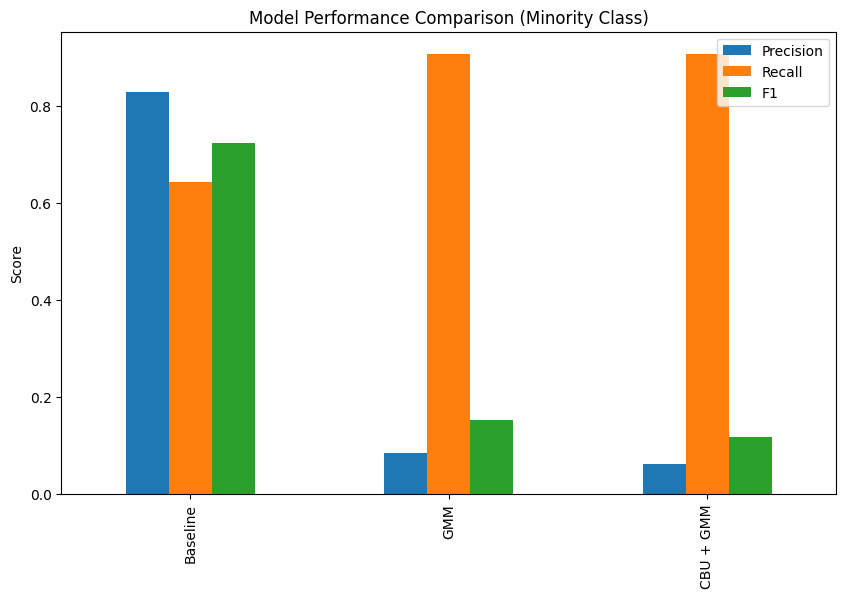

In [32]:
from tabulate import tabulate

def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return [precision, recall, f1]

metrics = {
    "Baseline": get_metrics(y_test, y_pred),
    "GMM": get_metrics(y_test, y_pred_gmm),
    "CBU + GMM": get_metrics(y_test, y_pred_cbu_gmm)
}

print("\nPerformance Comparison:")
print(tabulate([(k, *v) for k,v in metrics.items()], headers=["Model","Precision","Recall","F1"]))

comparison_df = pd.DataFrame(metrics, index=["Precision","Recall","F1"])
comparison_df.T.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison (Minority Class)")
plt.ylabel("Score")
plt.show()

### Interpretation:

1. Baseline (without resampling)

- Precision is very high (~0.83): When the model predicts fraud, it is usually correct.
- Recall is moderate (~0.64): The model misses a significant fraction of fraud cases.
- F1-score (~0.72): Balanced performance.

2. GMM Oversampling

- Recall shoots up to ~0.91: The model becomes much better at detecting fraud.
- Precision drops drastically (~0.09): Most of the predicted frauds are false alarms.
- F1-score drops (~0.15): Overall performance worsens despite high recall.

3. CBU + GMM

- Very similar to GMM-only: high recall (0.91), low precision (0.08), poor F1 (~0.14).
- Clustering-based undersampling didn’t fix the precision-recall tradeoff.

### Conclusion:

Based on both results and theoretical understanding:

1. Effectiveness of GMM in this context:

- GMM oversampling does improve recall significantly (good for not missing frauds).
- However, the drop in precision and F1 shows that synthetic samples from GMM may not represent the true minority distribution well. They might confuse the classifier by overlapping too much with majority class space.
- Thus, the tradeoff is poor: you detect almost all frauds but at the cost of flagging many normal transactions.

2. Recommendation:

- Do not rely on GMM oversampling alone in this fraud detection setting.
- It can be useful if high recall is absolutely critical (e.g., catching all frauds and letting humans investigate flagged cases).
- But for a balanced automated system, GMM oversampling is not recommended due to poor precision and F1.
